# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as ply
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Load and Explore Data

In [2]:
# Load Training and Test set
housing = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
housing_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
# View training set
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# View test set
housing_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# Get more information on SalePrice
housing['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The above description tells us that there is a total of 1460 entries with mean SalePrice as 180921 (approx) and maximum as 755000.

### Correlation in Data

In [6]:
# We will create a correlation matrix and 
# use spearman method to calulate correlation.
corr_matrix = housing.corr(method='spearman')
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.809829
GrLivArea        0.731310
GarageCars       0.690711
YearBuilt        0.652682
GarageArea       0.649379
FullBath         0.635957
TotalBsmtSF      0.602725
GarageYrBlt      0.593788
1stFlrSF         0.575408
YearRemodAdd     0.571159
TotRmsAbvGrd     0.532586
Fireplaces       0.519247
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.421309
LotFrontage      0.409076
WoodDeckSF       0.353802
HalfBath         0.343008
BsmtFinSF1       0.301871
2ndFlrSF         0.293598
BedroomAbvGr     0.234907
BsmtFullBath     0.225125
BsmtUnfSF        0.185197
ScreenPorch      0.100070
MoSold           0.069432
3SsnPorch        0.065440
PoolArea         0.058453
MSSubClass       0.007192
BsmtHalfBath    -0.012189
Id              -0.018546
YrSold          -0.029899
BsmtFinSF2      -0.038806
MiscVal         -0.062727
LowQualFinSF    -0.067719
OverallCond     -0.129325
KitchenAbvGr    -0.164826
EnclosedPorch   -0.218394
Name: SalePr

# Cleaning Data

In [7]:
# Now we will separate text data but keep 'SalePrice' attribute for correlations
housing_text_price = housing[['MSZoning', 'Utilities', 'LandContour',
                       'LotConfig', 'Condition1', 'Condition2', 'ExterQual',
                       'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                       'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                       'GarageCond', 'Neighborhood', 'SalePrice']]
housing_text_price_test = housing_test[['MSZoning', 'Utilities', 'LandContour',
                       'LotConfig', 'Condition1', 'Condition2', 'ExterQual',
                       'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                       'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                       'GarageCond', 'Neighborhood']]

housing_text_price.head()

,MSZoning,Utilities,LandContour,LotConfig,Condition1,Condition2,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageQual,GarageCond,Neighborhood,SalePrice
0,RL,AllPub,Lvl,Inside,Norm,Norm,Gd,TA,Gd,TA,Ex,Y,Gd,NaN,TA,TA,CollgCr,208500
1,RL,AllPub,Lvl,FR2,Feedr,Norm,TA,TA,Gd,TA,Ex,Y,TA,TA,TA,TA,Veenker,181500
2,RL,AllPub,Lvl,Inside,Norm,Norm,Gd,TA,Gd,TA,Ex,Y,Gd,TA,TA,TA,CollgCr,223500
3,RL,AllPub,Lvl,Corner,Norm,Norm,TA,TA,TA,Gd,Gd,Y,Gd,Gd,TA,TA,Crawfor,140000
4,RL,AllPub,Lvl,FR2,Norm,Norm,Gd,TA,Gd,TA,Ex,Y,Gd,TA,TA,TA,NoRidge,250000


In [8]:
# Solution for Missing Values
imputer = SimpleImputer(strategy="median")
# Median can be calculated for numeric values so we will drop non-numeric values
housing_num = housing[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
               'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'TotRmsAbvGrd',
               'Fireplaces', 'LotFrontage', 'LotArea', 'MasVnrArea', 'GarageYrBlt']]
imputer.fit(housing_num)

housing_num_test = housing_test[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
               'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'TotRmsAbvGrd',
               'Fireplaces', 'LotFrontage', 'LotArea', 'MasVnrArea', 'GarageYrBlt']]
imputer.fit(housing_num_test)

SimpleImputer(strategy='median')

In [9]:
# Use the trained Imputer to transform (replace missing values)
# in our existing numeric data 
X = imputer.transform(housing_num)
Y = imputer.transform(housing_num_test)

In [10]:
# The results of imputer were NumPy arrays
# Therefore we convert them back to pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                         index=housing_num.index)

housing_tr_test = pd.DataFrame(Y, columns=housing_num_test.columns, 
                         index=housing_num_test.index)

### Handling Text and Categorical Data

In [11]:
# To find features with missing values
housing_text = housing[['MSZoning', 'Utilities', 'LandContour',
                       'LotConfig', 'Condition1', 'Condition2', 'ExterQual',
                       'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                       'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                       'GarageCond', 'Neighborhood']]

housing_text_test = housing_test[['MSZoning', 'Utilities', 'LandContour',
                       'LotConfig', 'Condition1', 'Condition2', 'ExterQual',
                       'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                       'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageQual',
                       'GarageCond', 'Neighborhood']]

housing_text.isna().sum()

MSZoning          0
Utilities         0
LandContour       0
LotConfig         0
Condition1        0
Condition2        0
ExterQual         0
ExterCond         0
BsmtQual         37
BsmtCond         37
HeatingQC         0
CentralAir        0
KitchenQual       0
FireplaceQu     690
GarageQual       81
GarageCond       81
Neighborhood      0
dtype: int64

We will replace these missing values because they are larger in number and dropping them won't be a good idea.

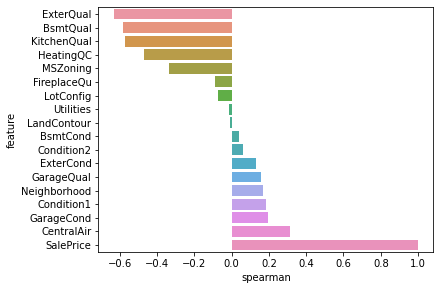

In [12]:
def spearman(frame, features):
    """
    A function to plot a graph with given feature's 
    correlation with the attribute 'SalePrice'.
    """
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

spearman(housing_text_price, housing_text_price.columns)

In [13]:
# Clearly from the visuals above we will use features of our interest (closely related with SalePrice)
housing_text = housing[['Condition1', 'Condition2','ExterCond', 
                        'BsmtCond', 'CentralAir', 'GarageQual', 
                        'GarageCond', 'Neighborhood']]
housing_text.fillna('Unavailable', inplace=True)

housing_text_test = housing_test[['Condition1', 'Condition2','ExterCond', 
                        'BsmtCond', 'CentralAir', 'GarageQual', 
                        'GarageCond', 'Neighborhood']]
housing_text_test.fillna('Unavailable', inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [14]:
# Use Ordinal Encoder for categorical and text attributes
ordinal_encoder = OrdinalEncoder()
housing_text_enc = ordinal_encoder.fit_transform(housing_text)
housing_text = pd.DataFrame(housing_text_enc,
                            columns=['Condition1', 'Condition2','ExterCond', 
                                    'BsmtCond', 'CentralAir', 'GarageQual', 
                                    'GarageCond', 'Neighborhood'])

ordinal_encoder_test = OrdinalEncoder()
housing_text_enc_test = ordinal_encoder.fit_transform(housing_text_test)
housing_text_test = pd.DataFrame(housing_text_enc_test,
                            columns=['Condition1', 'Condition2','ExterCond', 
                                    'BsmtCond', 'CentralAir', 'GarageQual', 
                                    'GarageCond', 'Neighborhood'])

In [15]:
# Combine both numerical and categorical data as 'housing_prep'
dataframes = [housing_tr, housing_text, housing["Id"]]
housing_prep = pd.concat(dataframes, axis=1)


dataframes1 = [housing_tr_test, housing_text_test, housing_test["Id"]]
housing_prep_test = pd.concat(dataframes1, axis=1)

housing_prep_test.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,TotRmsAbvGrd,Fireplaces,...,GarageYrBlt,Condition1,Condition2,ExterCond,BsmtCond,CentralAir,GarageQual,GarageCond,Neighborhood,Id
0,5.0,896.0,1.0,730.0,882.0,896.0,1.0,1961.0,5.0,0.0,...,1961.0,1.0,2.0,4.0,3.0,1.0,3.0,4.0,12.0,1461
1,6.0,1329.0,1.0,312.0,1329.0,1329.0,1.0,1958.0,6.0,0.0,...,1958.0,2.0,2.0,4.0,3.0,1.0,3.0,4.0,12.0,1462
2,5.0,1629.0,2.0,482.0,928.0,928.0,2.0,1997.0,6.0,1.0,...,1997.0,2.0,2.0,4.0,3.0,1.0,3.0,4.0,8.0,1463
3,6.0,1604.0,2.0,470.0,926.0,926.0,2.0,1998.0,7.0,1.0,...,1998.0,2.0,2.0,4.0,3.0,1.0,3.0,4.0,8.0,1464
4,8.0,1280.0,2.0,506.0,1280.0,1280.0,2.0,1992.0,5.0,0.0,...,1992.0,2.0,2.0,4.0,3.0,1.0,3.0,4.0,22.0,1465


# Select and Train Model

In [16]:
# Create a housing label i.e. SalePrice
housing_label = housing["SalePrice"].copy()

# We will use RandomForestRegressor to train our model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prep, housing_label)

RandomForestRegressor()

In [17]:
def display_scores(scores):
  """Shows values of Cross-Validation score."""
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

In [18]:
# Check our model score using cross-validation
forest_score = cross_val_score(forest_reg, housing_prep, housing_label,
                              scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_score)
display_scores(forest_rmse_scores)

Scores: [29500.02297609 28038.45298207 23217.74020024 43129.02901322
 37075.94666754 23820.74357051 25511.81757233 25612.33896773
 39244.49001459 29176.78655136]
Mean: 30432.736851567937
Standard deviation: 6590.7612673789745


In [19]:
housing_prep_test1 = housing_prep_test.copy()
housing_prep_test1.dropna(inplace=True)
# Make predictions on test set
predictions = forest_reg.predict(housing_prep_test1)

# Conert our predictions to a DataFrame
output = pd.DataFrame({'Id': housing_prep_test1.Id, 'SalePrice': predictions})
# Convert our DataFrame to a CSV file
output.to_csv('submission.csv', index=False)
print("Submitted successfully!")

Submitted successfully!
